<a href="https://colab.research.google.com/github/Rajkdea123/Fake_News_Detection/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [3]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    return train_acc, test_acc

In [4]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange:
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term

    return lb, ub

In [5]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [6]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


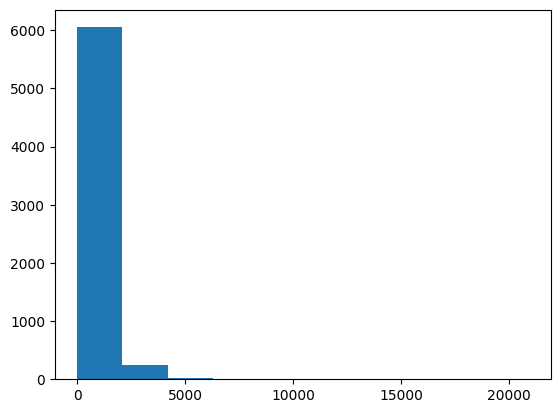

In [7]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

**Naive Bayes**

In [8]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word",
                             binary = True,
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [9]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [10]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

In [11]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 94.65%
Testing Accuracy: 89.11%


In [12]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 87.39%-90.82%


**Convolutional DNN**

In [13]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.13.1 which is incompatible.


In [14]:
!pip uninstall keras -y
!pip uninstall tensorflow -y
!pip install tensorflow

Found existing installation: keras 2.13.1
Uninstalling keras-2.13.1:
  Successfully uninstalled keras-2.13.1
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.4 MB/s eta 0:00:00
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 46.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard
    Found existing installati

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1),
                                                  test_size=TEST_SPLIT)

In [18]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 300)         3000300   
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3209069 (12.24 MB)
Trainable params: 3209069 (12.24 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [19]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 468s 12s/step - loss: 0.6408 - accuracy: 0.6358 - val_loss: 0.5004 - val_accuracy: 0.7845
Epoch 2/10
40/40 [==============================] - 478s 12s/step - loss: 0.3650 - accuracy: 0.8461 - val_loss: 0.2591 - val_accuracy: 0.9100
Epoch 3/10
40/40 [==============================] - 472s 12s/step - loss: 0.1944 - accuracy: 0.9321 - val_loss: 0.2083 - val_accuracy: 0.9148
Epoch 4/10
40/40 [==============================] - 479s 12s/step - loss: 0.1036 - accuracy: 0.9700 - val_loss: 0.1942 - val_accuracy: 0.9148
Epoch 5/10
40/40 [==============================] - 471s 12s/step - loss: 0.0570 - accuracy: 0.9856 - val_loss: 0.1575 - val_accuracy: 0.9408
Epoch 6/10
40/40 [==============================] - 477s 12s/step - loss: 0.0231 - accuracy: 0.9974 - val_loss: 0.1347 - val_accuracy: 0.9526
Epoch 7/10
40/40 [==============================] - 475s 12s/step - loss: 0.0084 - accuracy: 0.9998 - val_loss: 0.1365 - val_accuracy: 0.9503
Epoch 

In [20]:
# all possible parameters history stores
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

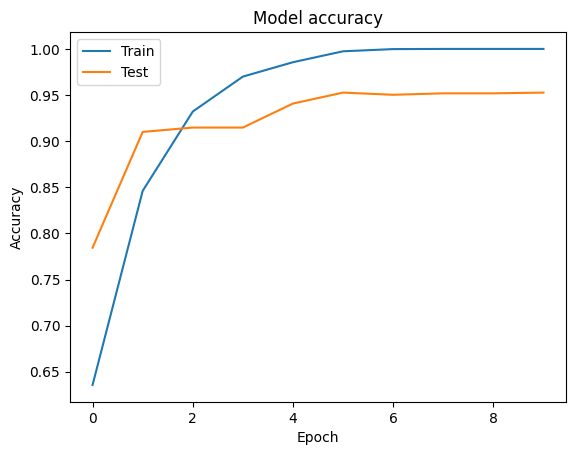

In [21]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
# evaluate model

train_acc, test_acc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_val,
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

40/40 [==============================] - 44s 1s/step
Training Accuracy: 100.00%
Testing Accuracy: 95.26%


In [23]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 94.09%-96.43%
